# Problem Set 5: Neural Nets for Factor Investing

California Institute of Technology

BEM 114: Hedge Funds

Spring 2024


Due: May 19th, 2024

Please submit your assignments on Canvas before 11:59 p.m. on the due date. Please upload both the Jupyter (iPython) notebook and a PDF of the notebook.  You do not need to submit the data.



## Introduction
In this problem set you will fit a simple feed-forward Neural Net in order to demonstrate how a neural net can be used to identify dependencies across factors in order to create a higher alpha.

In question 1 we'll explore the comparison of a neural net to a linear model fit, and demonstrate some of the reasoning why a ReLU activation function is a common choice for neural nets in finance. In question 2 we'll analyze whether lag parameters may help further increase the performance of our model. In question 3 we'll investigate the importance of checking and robustness and reproducibility of the results of our fit.

I have included some sample output as a sanity check for some questions. As discussed in question 3, the optimization of the neural net uses a stochastic component, and thus, your estimates will be slightly different from when you see here.

## Starting Code
You'll be asked to update the following starting code in order to update the model being fit. This will include model parameters, as well as updating the input space.

The `fitting_returns_data` function is the main function that we'll run in order to pull results.

The functions with an `io_` prefix define input and output variables. The functions with a `'model_` prefix define the model fit that we'll be using.

This problem set will ask you to create your own `io_` and `model_` functions in order to test different modeling possibilities, and to determine the importance of these decisions in the model fitting process.

In [ ]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
import warnings




# We'll suppress some warnings from tensorflow, but feel free to
# comment out this line and see some of the efficiency gains we can get!
warnings.filterwarnings("ignore")


# Note: All io_fns and model_fns start with an 'io_' and 'model_' prefix
# respectively



def fitting_returns_data(data_path,
                         io_fn,
                         model_fn,
                         seed = 519,
                         print_summary = True):
    """
    Fits data to supplied model and provides returns and alpha estimates.

        Parameters:
            data_path (str): path to factor data with first column as date
                6 factors, and the last column as risk free rate
            io_fn (fn): a function to calculate input/output pairs for the
                model fit
            model_fn (fn): a function that takes in input data, output data,
                and training and testing values, and returns the strategy
                for each day, and the observed return for each day
            seed (int): if given, the seed for the model fit will be set to
                this value
            print_summary (bool): if True, then the model won't print a summary
                of the OLS fit for our strategy return.
        Returns:
            strat_df (pd.DataFrame): The weights we would give each factor
                on each day
            return_vector (list): The returns from our strategy on each day
            model_OLS (RegressionResultsWrapper): A regression calculating the
                alpha for our strategy
    """
    # if given, set the random seed
    if seed:
        set_seed(seed)

    # Load the data into a pandas DataFrame
    data = pd.read_csv(data_path)
    # Drop date and risk free rate
    data = data.iloc[:, 1:7]

    # Shift the data by one time step to create input/output pairs
    X, y = io_fn(data)

    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

    # Fit the model
    strat_df, return_vector = model_fn(X, y, X_train, y_train, X_val, y_val)

    # Calculate alpha
    y_ols = sm.add_constant(y)
    model_OLS = sm.OLS(return_vector, y_ols).fit()
    if print_summary:
        print(model_OLS.summary())

    # print(return_vector)
    # print(min(return_vector))
    # print(max(return_vector))
    # print(len([x for x in return_vector if x > 0]))
    return strat_df, return_vector, model_OLS


def set_seed(seed_value):
    # Adding a fixed seed from this solution: https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras
    # 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(seed_value)

    # 2. Set the `python` built-in pseudo-random generator at a fixed value
    random.seed(seed_value)

    # 3. Set the `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)

    # 4. Set the `tensorflow` pseudo-random generator at a fixed value
    tf.compat.v1.set_random_seed(seed_value)
    return

def io_day_1_lag(data):
    # Create input output pairs, where the input is the previous day of data
    # and the output is the current day of data.
    X = data.shift(1).dropna().reset_index(drop=True)
    y = data.dropna().iloc[1:,:].reset_index(drop=True)
    return X, y

def io_day_1_lag_second_order_input(data):
    # Create input output pairs where input data includes second order interactions
    X, y = io_day_1_lag(data)
    cols = X.columns

    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            col_name = cols[i] + cols[j]
            col_values = X[cols[i]] * X[cols[j]]
            X[col_name] = col_values
    return X, y

def model_feed_forward(X, y, X_train, y_train, X_val, y_val):
    # Define the neural network model
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=(X.shape[1],)))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(6, activation='linear'))

    # Compile the model
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Train the model, verbose = 0 means reports aren't printed
    # at the end of each epoch
    model.fit(X_train, y_train, batch_size=32, epochs=50,
              validation_data=(X_val, y_val), verbose=0)

    # Make predictions
    predictions = model.predict(X)

    pred_df = pd.DataFrame(predictions)

    return predictions_to_returns(pred_df, y)

def predictions_to_returns(pred_df, y):
    # Given the predictions of each factor for each day, calculate our
    # strategy for each day, and the returns for each day

    # Apply our strategy to our predictions
    strat_df = pred_df.apply(lambda row : max_predicted_factor_strat(row), axis = 1)

    # Calculate our returns
    return_vector = np.multiply(strat_df,np.asarray(y)).apply(sum, axis = 1)

    return strat_df, return_vector


def max_predicted_factor_strat(row):
    # For each day, set our strategy to be the factor with
    # the highest predicted return
    max_pred_return = max(row)
    row_list = [x == max_pred_return for x in row]
    return pd.Series(row_list)

## Question 0 - Run the Neural Net and Interpet the alpha
The following code fits a feed-forward neural net on all data, and prints a summary.
Run the code and provide an interpretation of the alpha.

```
fitting_returns_data(
    'ff6_factors_19630701_20230131.csv',
    io_day_1_lag,
    model_feed_forward);
```

**Note**: The test-train split we're employing in these model fits is faulty. We use data from the future to predict our model, so all results here have some level of overfitting. However, I separately fit the models by only using past data, and we were able to get similar results, so the results still seem robust to the potential overfitting.

### Question 0 Solution

In [ ]:
# Calculate returns and alphas using feed forward neural net model
fitting_returns_data(
    '/content/ff6_factors_19630701_20230131.csv',
    io_day_1_lag,
    model_feed_forward);

469/469 [==============================] - 1s 1ms/step
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     431.8
Date:                Mon, 20 May 2024   Prob (F-statistic):               0.00
Time:                        03:35:43   Log-Likelihood:                -15710.
No. Observations:               14998   AIC:                         3.143e+04
Df Residuals:                   14991   BIC:                         3.149e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

## Question 1 - Comparing Neural Net to OLS

### 1ai [20 points] Set a linear activation function
For the feed-forward neural net that is fit above, the `model_feed_forward` function sets up activation across hidden layers with the following code:

```
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(6,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(6, activation='linear'))
```

Write a new function called `model_feed_forward_linear`, which changes the `'relu'` parameter to `'linear'`.


Calculate reults for the neural net with linear activation. How does this compare to the ReLU activation from Question 0?

*Answer: we see from the results below that the linear activation function produces an alpha a little lower than the relu activation function. This makes sense as noted in the problem set introduction that the ReLu activation function is known to be the ideal activation function in network architecture for investment strategies*

### Solution 1ai

In [ ]:
# Define linear feed-forward neural net based on model_feed_forward

def model_feed_forward_linear(X, y, X_train, y_train, X_val, y_val):
    # Define the neural network model
    model = Sequential()
    model.add(Dense(32, activation='linear', input_shape=(X.shape[1],)))
    model.add(Dense(16, activation='linear'))
    model.add(Dense(6, activation='linear'))

    # Compile the model
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Train the model, verbose = 0 means reports aren't printed
    # at the end of each epoch
    model.fit(X_train, y_train, batch_size=32, epochs=50,
              validation_data=(X_val, y_val))

    # Make predictions
    predictions = model.predict(X)

    pred_df = pd.DataFrame(predictions)

    return predictions_to_returns(pred_df, y)

# Calculate returns and alphas from linear neural net

fitting_returns_data(
    'ff6_factors_19630701_20230131.csv',
    io_day_1_lag,
    model_feed_forward_linear);


Epoch 1/50
375/375 [==============================] - 2s 3ms/step - loss: 0.4409 - val_loss: 0.4450
Epoch 2/50
375/375 [==============================] - 1s 2ms/step - loss: 0.4226 - val_loss: 0.4450
Epoch 3/50
375/375 [==============================] - 1s 3ms/step - loss: 0.4217 - val_loss: 0.4446
Epoch 4/50
375/375 [==============================] - 1s 4ms/step - loss: 0.4206 - val_loss: 0.4527
Epoch 5/50
375/375 [==============================] - 1s 3ms/step - loss: 0.4213 - val_loss: 0.4448
Epoch 6/50
375/375 [==============================] - 1s 3ms/step - loss: 0.4201 - val_loss: 0.4466
Epoch 7/50
375/375 [==============================] - 1s 2ms/step - loss: 0.4205 - val_loss: 0.4462
Epoch 8/50
375/375 [==============================] - 1s 2ms/step - loss: 0.4211 - val_loss: 0.4473
Epoch 9/50
375/375 [==============================] - 1s 2ms/step - loss: 0.4197 - val_loss: 0.4479
Epoch 10/50
375/375 [==============================] - 1s 2ms/step - loss: 0.4198 - val_loss: 0.4540


### 1aii [10 points] Compare with linear model

The following code defines a function called `model_linear_fit`, which fits a linear model on y_train and X_train and outputs the predicted return given `X`, called `pred_df`. The function then calculates the  returns of the linear model by running `predictions_to_returns(pred_df, y)`.

Since the neural net is only fitting on linear relationships, we should see similar results across the linear neural net and the linear OLS model here.

Calculate reults for the linear model below. How does the alpha compare to the linear neural net?  

*Answer: we see from the results below that the linear model produces a slightly lower alpha compared to the linear neural net which makes sense as the amount of linear weights that the linear neural net can train on and the additional layers allowing for the model to learn interactions between variable of the input space on various levels should allow for more accurate learning compared to an OLS and thus result in better investment decisions as seen by the higher alpha*

### Solution 1aii

In [ ]:
# Define linear OLS model
## Linear Model Fit
def model_linear_fit(X, y, X_train, y_train, X_val, y_val):
    model_OLS = sm.OLS(y_train, X_train).fit()
    # Make predictions
    predictions = model_OLS.predict(X)

    pred_df = pd.DataFrame(predictions)

    return predictions_to_returns(pred_df, y)

# Calculate returns and alphas using linear OLS model

fitting_returns_data(
    'ff6_factors_19630701_20230131.csv',
    io_day_1_lag,
    model_linear_fit);


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     363.2
Date:                Mon, 20 May 2024   Prob (F-statistic):               0.00
Time:                        03:37:01   Log-Likelihood:                -15513.
No. Observations:               14998   AIC:                         3.104e+04
Df Residuals:                   14991   BIC:                         3.109e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0904      0.006     16.202      0.0

### 1b [20 points] Include Interaction Terms
Linear models don't account for any interaction effects. In order to account for an interaction we can add input variables that give the product of factor returns on each day. This would be analogous to adding a interaction term to a linear model.

Using the io_ function `io_day_1_lag_second_order_input`, and your `model_linear_fit` function, calculate returns while including second order inputs.

Write a new io_ function `io_day_lag_third_order_input`, to also include third order fits in your input data.

How do these models compare to the ReLU alpha?

*Answer: We see that both models produce improvements upon eachother and from the original first order linear model fit (~.095 and ~.10 respectively), but not as high as the ReLU alpha. The improvement makes sense as expanding the input space to consider interations of first order inputs with each other adds more information for the model to learn and thus improve on. Although an improvement it does not reach the alpha of the ReLU activation neural net which makes sense as neural nets through their many layers can and significantly more weights to train, can also incorporate these higher order interactions in their fitting.*


### Solution 1b

In [ ]:
# Calculate returns and alphas using second order interactions

fitting_returns_data(
    'ff6_factors_19630701_20230131.csv',
    io_day_1_lag_second_order_input,
    model_linear_fit);


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     489.2
Date:                Mon, 20 May 2024   Prob (F-statistic):               0.00
Time:                        03:37:45   Log-Likelihood:                -16116.
No. Observations:               14998   AIC:                         3.225e+04
Df Residuals:                   14991   BIC:                         3.230e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0965      0.006     16.615      0.0

In [ ]:
# Define function for calculating third order interactions based on io_day_1_lag_second_order_input

def io_day_1_lag_third_order_input(data):
    # Create input output pairs where input data includes second order interactions
    X, y = io_day_1_lag(data)
    cols = X.columns

    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            col_name = cols[i] + cols[j]
            col_values = X[cols[i]] * X[cols[j]]
            X[col_name] = col_values
            for k in range(j+1, len(cols)):
              third_col_name = col_name + cols[k]
              third_col_values = X[col_name] * X[cols[k]]
              X[third_col_name] = third_col_values

    return X, y


# Calculate returns and alphas using third order interactions

fitting_returns_data(
    'ff6_factors_19630701_20230131.csv',
    io_day_1_lag_third_order_input,
    model_linear_fit);


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     370.6
Date:                Mon, 20 May 2024   Prob (F-statistic):               0.00
Time:                        03:38:22   Log-Likelihood:                -16006.
No. Observations:               14998   AIC:                         3.203e+04
Df Residuals:                   14991   BIC:                         3.208e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1048      0.006     18.181      0.0

## Question 2 - Adding Time Lag Parameters
### 2 [25 points] Lag Time Parameters
Our current neural net only uses the past 1 day of data. For time series data, including more lag days can be useful. For example, if a factor return is high for 2 consecutive days, that may be more informative than just knowing that the return was only high for the previous day.

In this question, we will simply add a new column to our input data for each lagged data. This is analogous to an AutoRegressive Model, which is a popular financial engineering tool, [see this textbook](https://link.springer.com/book/10.1007/978-1-4939-2614-5). In the Neural Net literature, a Recurrent Neural Net is a common tool for more directly accounting for time lagged data directly in the neural net architecture, but the lagged model gets us a good amount of the way there!

Starting from the `io_day_1_lag` function write an `io_day_5_lag` function, which adds to the input dataframe 5 days of lagged data per factor. This will mean your input data will now have 6*5 = 30 columns instead of 6 columns.

When complete, run the following and compare results to the original ReLU model from Question 0. How do the results compare? Should we continue to to pursue incorporating lag effects in our analysis of this data?

*Answer: As seen from the results of the ff6 model on the ReLu neural net strategy with 5-day lagged data as the input space, we notice that the alpha improves significantly from ~.12 to ~.15 (statistically significant difference as noticed by the low standard deviations on the estimates relative to the difference). Thus, the results support continuing to pursue lagged effects into the analysis.*

```
fitting_returns_data(
    'ff6_factors_19630701_20230131.csv',
    io_day_5_lag,
    model_feed_forward);
 ```

 ### Question 2 Solution

In [ ]:
# Define function for calculating five-day lags based on io_day_1_lag

def io_day_5_lag(data):
    # Create input output pairs, where the input is the previous day of data
    # and the output is the current day of data.

    lags = []

    for i in range(0,5):
      X = data.shift(i+1).dropna().reset_index(drop=True)
      X = X.dropna().iloc[5 - (i + 1):,:].reset_index(drop = True)
      lags.append(X)

    X = pd.concat(lags, axis = 1)


    y = data.dropna().iloc[5:,:].reset_index(drop=True)
    return X, y

# Calculate returns and alphas using the feed forward neural net with
# five day lagged input variables.

fitting_returns_data(
    'ff6_factors_19630701_20230131.csv',
    io_day_5_lag,
    model_feed_forward);


469/469 [==============================] - 1s 1ms/step
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                     1031.
Date:                Mon, 20 May 2024   Prob (F-statistic):               0.00
Time:                        03:39:39   Log-Likelihood:                -16382.
No. Observations:               14994   AIC:                         3.278e+04
Df Residuals:                   14987   BIC:                         3.283e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

## Question 3 - Investigating Potentials for P-Hacking
### 3 [25 points] Randomness in Alphas

Neural  nets are fit via a Stochastic Gradient Descent. This implies that there is inherent randomness in any fit of the model. One good way to account for this noise in your model is to refit the model multiple times and observe the distribution. It's more accurate to report the median or mean of these estimates, although it can be hard to tell if a paper/report has cherry-picked the best result in this way.

Using the `io_day_1_lag`, and `model_feed_forward` settings, rerun the model 100 times and get a distribution for the alpha given. (You can use the `seed` parameter in the `fitting_returns_data` function if you want to be able to reproduce a given high return.)

Set `print_summary = False` in `fitting_returns_data` in order to avoid large amounts of output.

What's the highest return you could get if you were to ignore the importance of the robustness of a model result? What would be a downside of reporting a result like this?

Note: running the model 100 times may take awhile (over an hour on Google Colab). Debug your code before attempting the 100 cycles.

### Question 3 Solution


*Answer: If we were to ignore the importance of the robustness of a model result, then we could potentially report an alpha value of 0.13449569123978977, which was the maximum alpha value over our 100 iterations. This would be disingenuous because if someone tried to replicate the strategy, they may be shocked to see lower returns. In this specific example, the median alpha result is approximately 0.123, 1% less than the reported maximum.*

Iteration #0
469/469 [==============================] - 1s 1ms/step
0.11168479812435413
469/469 [==============================] - 1s 1ms/step
0.12791431347836366
469/469 [==============================] - 1s 1ms/step
0.12073296058929114
469/469 [==============================] - 1s 3ms/step
0.12412477379330993
469/469 [==============================] - 1s 2ms/step
0.12334206653548256
469/469 [==============================] - 1s 1ms/step
0.12537576834832298
469/469 [==============================] - 1s 2ms/step
0.12038091111153383
469/469 [==============================] - 1s 2ms/step
0.13449569123978977
469/469 [==============================] - 1s 2ms/step
0.1252492985290276
469/469 [==============================] - 1s 2ms/step
0.12073909341510358
Iteration #10
469/469 [==============================] - 1s 1ms/step
0.12343347093902757
469/469 [==============================] - 1s 1ms/step
0.121551508475182
469/469 [==============================] - 1s 1ms/step
0.1242944561325483
46

(array([ 2.,  2.,  4., 11., 31., 21., 15.,  8.,  4.,  2.]),
 array([0.11036258, 0.11277589, 0.1151892 , 0.11760252, 0.12001583,
        0.12242914, 0.12484245, 0.12725576, 0.12966907, 0.13208238,
        0.13449569]),
 <BarContainer object of 10 artists>)

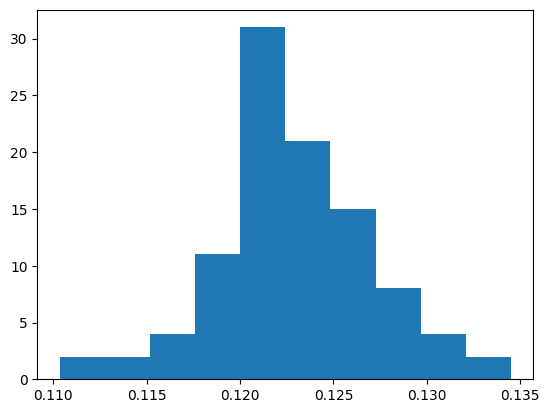

In [ ]:
# Rerun model 100 times
alphas = []
for i in range(100):
    if (i % 10 == 0):
      print(f'Iteration #{i}')
    strat_df, return_vector, model_OLS =  fitting_returns_data(
    'ff6_factors_19630701_20230131.csv',
    io_day_1_lag,
    model_feed_forward, print_summary = False);
    print(model_OLS.params[0])
    alphas.append(model_OLS.params[0])


plt.hist(alphas, bins = 10)